Представьте, что вы работаете аналитиком в компании, которая занимается арендой велосипедов. Коллега из офиса в Лондоне прислал вам данные за два года: с 4 января 2015 по 3 января 2017. Вам предстоит изучить динамику числа аренд, наличие связи с погодными условиями и выходными, а также объяснить несколько аномалий на графике.

1.	Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.

| Название      | Описание                                     |
|---------------|----------------------------------------------|
| timestamp     | Дата и время (точность до часа)              |
| cnt           | Количество аренд велосипедов за этот час    |
| t1            | Температура, в С                             |
| t2            | Температура "ощущается как", в С             |
| hum           | Влажность (%)                                |
| wind_speed    | Скорость ветра, км/ч                         |
| weather_code  | Погодные условия                              |
| isholiday     | Является ли день праздником (1 – праздник, 0 – нет) |
| isweekend     | Является ли день выходным (1 – выходной, 0 – нет) |
| season        | Метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима) |


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

data = pd.read_csv('3.6 london.csv', parse_dates=['timestamp'])
sns.set(rc={'figure.figsize': (16,6),'figure.dpi': (75)},style='darkgrid')

# сводная таблица
lst = []
for name in data.columns:
    nu = len(data[name].unique())
    nisnan = data[name].isnull().sum()
    min_val = data[name].min()
    max_val = data[name].max()
    values_sample = data[name].unique()[:min(nu,10)].tolist()
    lst.append([name,nu,nisnan, values_sample,min_val,max_val]) #
    
pd.DataFrame(lst,columns=['column','nunique','nnull','values','min','max']) # 

,column,nunique,nnull,values,min,max
0,timestamp,17414,0,"[2015-01-04 00:00:00, 2015-01-04 01:00:00, 201...",2015-01-04 00:00:00,2017-01-03 23:00:00
1,cnt,3781,0,"[182, 138, 134, 72, 47, 46, 51, 75, 131, 301]",0,7860
2,t1,73,0,"[3.0, 2.5, 2.0, 1.0, 1.5, 4.0, 5.0, 6.0, 6.5, ...",-1.5,34.0
3,t2,82,0,"[2.0, 2.5, 0.0, -1.0, -0.5, -1.5, 1.5, 1.0, 3....",-6.0,34.0
4,hum,143,0,"[93.0, 96.5, 100.0, 87.0, 90.0, 84.0, 81.0, 79...",20.5,100.0
5,wind_speed,103,0,"[6.0, 5.0, 0.0, 6.5, 4.0, 7.0, 8.0, 9.0, 12.0,...",0.0,56.5
6,weather_code,7,0,"[3.0, 1.0, 4.0, 7.0, 2.0, 26.0, 10.0]",1.0,26.0
7,is_holiday,2,0,"[0.0, 1.0]",0.0,1.0
8,is_weekend,2,0,"[1.0, 0.0]",0.0,1.0
9,season,4,0,"[3.0, 0.0, 1.0, 2.0]",0.0,3.0


2.	Постройте график по числу поездок по дате и времени.

<Axes: xlabel='timestamp', ylabel='cnt'>

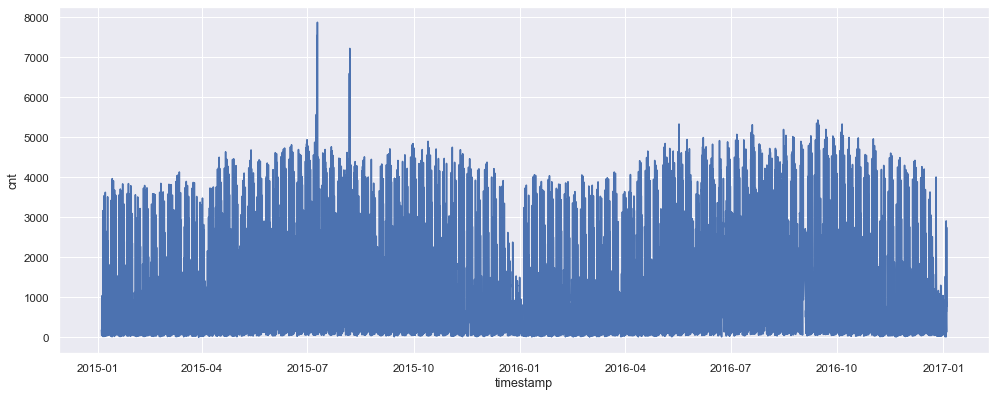

In [20]:
sns.lineplot(data=data, x= 'timestamp', y = 'cnt')

3.	Преобразуйте данные и посчитайте число поездок по дням. Визуализируйте результат.

In [21]:
data.sort_values(by='timestamp', inplace=True)# сортируем на всякий случай
data.set_index('timestamp',drop=False,inplace=True) # переносим даты в индекс, для resample

<Axes: xlabel='timestamp'>

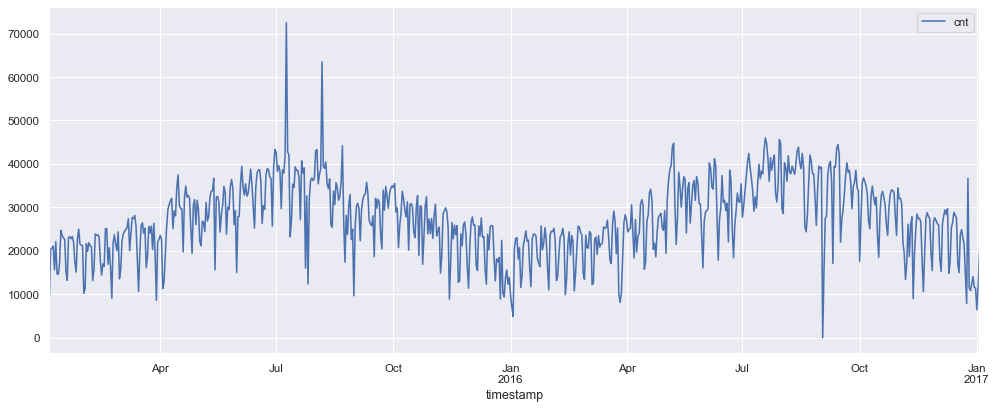

In [22]:
data.resample('D').agg({'cnt':'sum'}).plot()

4.	Используйте агрегированные данные по дням и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

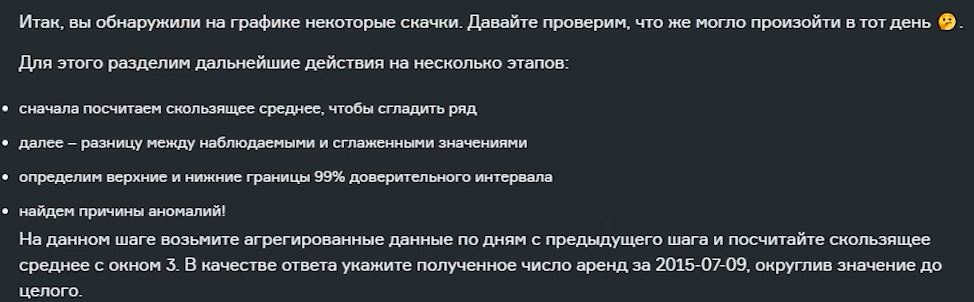

In [28]:
# скользящее среднее
df_by_day_roll = data.resample('D').cnt.sum().rolling(window=3).mean().reset_index()
df_by_day = data.resample('D').cnt.sum().reset_index()

<Axes: >

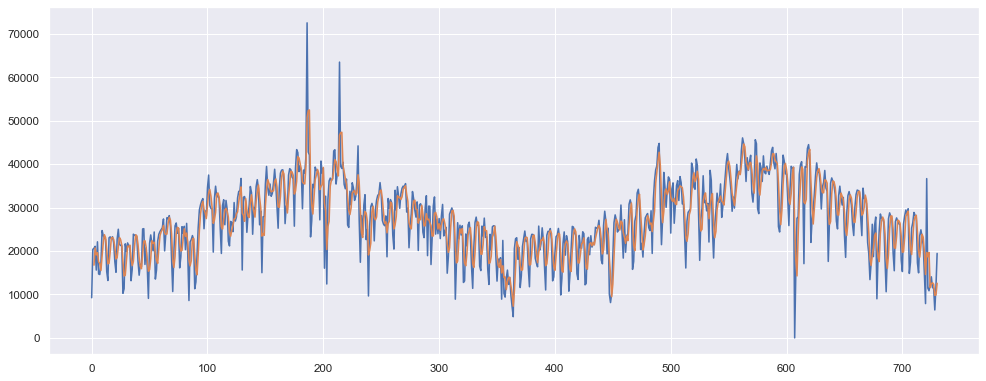

In [29]:
df_by_day.cnt.plot()
df_by_day_roll.cnt.plot()

In [30]:
df_by_day_roll.query("timestamp == '2015-07-09'")

,timestamp,cnt
186,2015-07-09,50705.0


5.	Посчитайте разницу между наблюдаемыми и значениями, подсчитанными с помощью скользящего среднего. Далее – найдите стандартное отклонение.

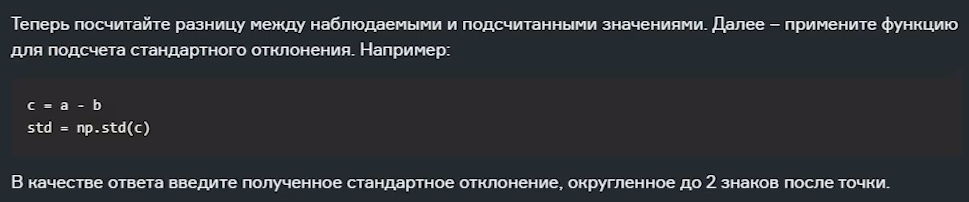

In [32]:
cnt_diff = df_by_day.cnt - df_by_day_roll.cnt
cnt_std = np.std(cnt_diff)
cnt_std.round(2)

4558.59

6.	Определите границы 99% доверительного интервала, добавьте данную информацию в датафрейм.

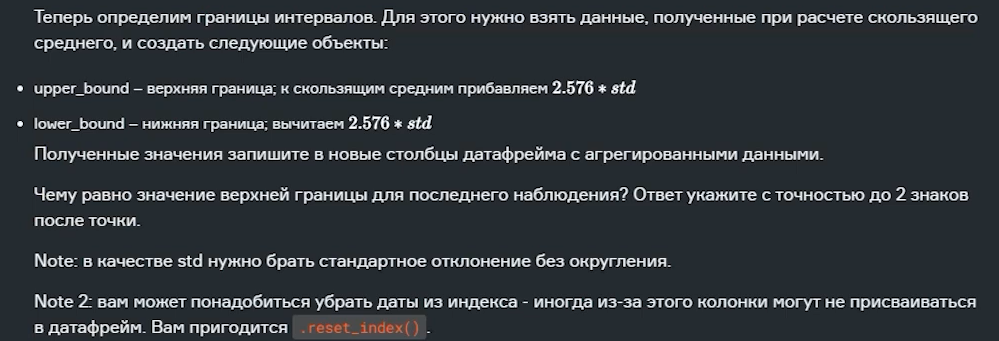

In [46]:
df_by_day['upper_bound'] = df_by_day_roll.cnt + 2.576 * cnt_std
df_by_day['lower_bound'] = df_by_day_roll.cnt - 2.576 * cnt_std

In [47]:
df_by_day

,timestamp,cnt,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,28482.594507,4996.738827
3,2015-01-07,21064,32425.927840,8940.072160
4,2015-01-08,15601,30835.594507,7349.738827
...,...,...,...,...
726,2016-12-30,11566,24424.927840,939.072160
727,2016-12-31,11424,24090.261173,604.405493
728,2017-01-01,6421,21546.594507,-1939.261173
729,2017-01-02,11823,21632.261173,-1853.594507


7.	Изучите аномально высокие значения и укажите день, когда число аренд было наибольшим. Найдите причину данной аномалии.

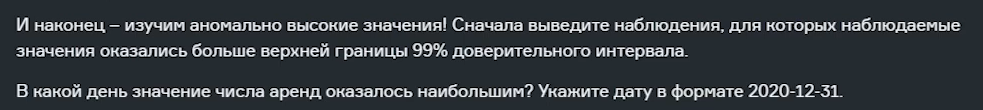

In [53]:
max_upper_bound = df_by_day.upper_bound.max()
df_by_day[(df_by_day['cnt'] > max_upper_bound)]

,timestamp,cnt,upper_bound,lower_bound
186,2015-07-09,72504,62447.92784,38962.07216


In [59]:
df_by_day[(df_by_day['cnt'] < df_by_day.lower_bound)]

,timestamp,cnt,upper_bound,lower_bound
130,2015-05-14,15609,40452.261173,16966.405493
189,2015-07-12,23240,47779.594507,24293.738827
201,2015-07-24,16034,42756.594507,19270.738827
232,2015-08-24,17400,41272.261173,17786.405493
314,2015-11-14,8898,32780.261173,9294.405493
607,2016-09-02,0,37829.261173,14343.405493
615,2016-09-10,17080,43004.927840,19519.072160
621,2016-09-16,21967,47936.261173,24450.405493
678,2016-11-12,8990,32620.927840,9135.072160


8.	Изучите аномально низкие значения, найдите день с наименьшим числом аренд. Найдите причину данной аномалии.

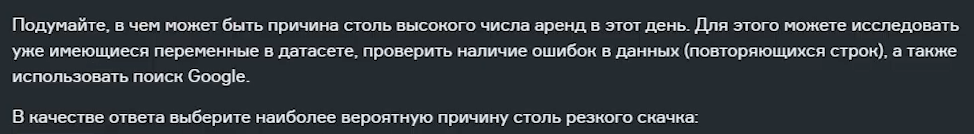

## 9 июля 2015 в лондоне было забастовки метро